# MA6202: Laboratorio de Ciencia de Datos

**Profesor: Nicolás Caro**

**05/06/2020 - E2 S9**


**Integrantes del grupo**:  Ignacio Fierro U, Fabián Badilla M., Juan Jose Maulen

## Ejercicio 2

La estructura de esta evaluación consta de 5 preguntas. Tenga en cuenta que un problema de programación puede (por lo general) resolverse de múltiples maneras. Sin embargo, para optar al puntaje completo en cada pregunta, siga las indicaciones de los enunciados y utilice solo herramientas vistas en el curso. 

En lo que sigue de la evaluación, **no** estará permitido usar librerías ni módulos diferentes a los declarados en la siguiente celda.

In [1]:
%load_ext line_profiler
%load_ext cython

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import pickle as pk
import os
import warnings
import math
import glob

from scipy import stats
from functools import lru_cache
from scipy import sparse 
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from multiprocessing import Process, cpu_count

El objetivo de este ejercicio es implementar **eficientemente** el algoritmo de regresión logística bayesiana, entrenado mediante un método de Markov Chain Montecarlo (MCMC), específicamente Metropolis-Hastings.

Para trabajar en esta evaluación, construya un repositorio Git y resuelva las preguntas de este notebook utilizando tal repositorio. El formato de entrega es un archivo **.zip** con el repositorio correspondiente a este trabajo, no olvide incluir la carpeta `.git` asociada.

### Preliminares

Se trabajará en un problema de **clasificación binaria** sobre un conjunto de datos. Tal conjunto, describe  el comportamiento de clientes en un banco frente a una llamada telefónica, en la cual se les ofrece un depósito a plazo. 

La variable objetivo del conjunto de datos describe si el cliente se subscribió o no luego de la llamada. Si bien no es necesario entender el significado de cada variable para el correcto desarrollo del ejercicio, en `data/readme.md` encontrarán una descripción de estas.

#### Carga de datos
Compruebe que la siguiente celda coincide con este output:

```
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           11162 non-null  int8    
 1   job           11162 non-null  category
 2   marital       11162 non-null  category
 3   education     11162 non-null  category
 4   default       11162 non-null  bool    
 5   balance       11162 non-null  int64   
 6   housing       11162 non-null  bool    
 7   loan          11162 non-null  bool    
 8   contact       11162 non-null  category
 9   month         11162 non-null  category
 10  campaign      11162 non-null  int64   
 11  pdays         11162 non-null  int64   
 12  previous      11162 non-null  int64   
 13  poutcome      11162 non-null  category
 14  outcome       11162 non-null  bool    
 15  day_of_week   11162 non-null  category
 16  log_duration  11162 non-null  float64 
dtypes: bool(4), category(7), float64(1), int64(4), int8(1)
memory usage: 568.7 KB
```

In [2]:
with open('data/trans_bank_marketing_codes-dtype.pk', 'rb') as file:
    
    dtypes_dict = pk.load(file)

reg_df = pd.read_csv('data/trans_bank_marketing_codes.csv', dtype=dtypes_dict)
reg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   age           11162 non-null  int8    
 1   job           11162 non-null  category
 2   marital       11162 non-null  category
 3   education     11162 non-null  category
 4   default       11162 non-null  bool    
 5   balance       11162 non-null  int64   
 6   housing       11162 non-null  bool    
 7   loan          11162 non-null  bool    
 8   contact       11162 non-null  category
 9   month         11162 non-null  category
 10  campaign      11162 non-null  int64   
 11  pdays         11162 non-null  int64   
 12  previous      11162 non-null  int64   
 13  poutcome      11162 non-null  category
 14  outcome       11162 non-null  bool    
 15  day_of_week   11162 non-null  category
 16  log_duration  11162 non-null  float64 
dtypes: bool(4), category(7), float64(1), int64(4), int

#### Preprocesamiento

Los datos son cargados y preprocesados según las herramientas vistas en el curso

In [3]:
# separar variables explicativas de objetivo
X = reg_df.loc[:, reg_df.columns[reg_df.columns != 'outcome']]
y = reg_df['outcome']

# separar conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

# categorizar las columnas para ColumnTransformer

int_cols = X_train.select_dtypes('int').columns.tolist()
float_cols = X_train.select_dtypes('float').columns.tolist()
bool_cols = X_train.select_dtypes('bool').columns.tolist()

one_hot_cols = X_train.select_dtypes('category').columns.tolist() + \
    X_train.select_dtypes('int8').columns.tolist()

# inicializar ColumnTransformer
col_trans = ColumnTransformer([
    ('continuous_std', StandardScaler(), float_cols),
    ('minmax', MinMaxScaler(), int_cols),
    ('passthrough_bool', 'passthrough', bool_cols),
    ('one_hot', OneHotEncoder(drop='first'), one_hot_cols)
])

# asegurar todas las columnas del conjunto de datos son utilizadas
assert X.columns.isin(int_cols + float_cols + bool_cols + one_hot_cols).all(), \
    'No todas las columnas son consideradas en ColumnTransformer'

# obtener los arreglos que se utilizaran en el ejercicio
X_mcmc = col_trans.fit_transform(X_train)
X_mcmc = sparse.hstack((np.ones((X_mcmc.shape[0], 1)), X_mcmc)) # agregar unos de la convencion
y_mcmc = y_train.astype(int).values

### Regresión logística Bayesiana

Dado un conjunto de observaciones para un problema de clasificación binario $\mathcal{D}= \{(\mathbf{x}_i, y_i)\}_{i=1}^{N} \in \mathbb{R}^{d} \times \{0,1\}$ el modelo de regresión logística se determina por:

$$
p(y_i = 1 | \mathbf{x}) = \sigma(\mathbf{w}^T\mathbf{x})
$$

donde:
$$
\sigma(\mathbf{w}^T\mathbf{x}) = \frac{1}{1 + \exp{(- \mathbf{w}^T\mathbf{x}})}
$$

Se asume la convención $\mathbf{x}_i = (x_i, 1) \forall i$, $x_i$ vector de características, esto permite codificar $\mathbf{w} \in \mathbb{R}^{d}$. La verosimilitud asociada a este modelo viene dada por:

$$
p(\mathbf{y} | \mathbf{w})=\prod_{n=1}^{N}  \sigma(\mathbf{w}^T\mathbf{x}_n)^{y_n}\left\{1-\sigma(\mathbf{w}^T\mathbf{x}_n)\right\}^{1-y_n}
$$

Si se escoge una probabilidad *prior* normal isotrópica $p(\mathbf{w})= \mathcal{N}\left(\mathbf{w} | \mathrm{\mu}_{w}, \sigma_w^2 I \right)$, el calculo de la distribución posterior $p(\mathbf{w} | \mathbf{y})$ se vuelve intratable. Esto pues, se hace necesario normalizar el producto de las probabilidades $p(\mathbf{y} | \mathbf{w})p(\mathbf{w})$, para lo cual no se tiene una expresión analítica. Por tal motivo, la distribución posterior predictiva

$$
p(\mathbf{y}_{*} | \mathbf{w},\mathbf{x}_{*}) = \int \sigma(\mathbf{w}^T\mathbf{x}_*) p(\mathbf{w} | \mathbf{y}) d\mathbf{w}
$$

no puede ser calculada de manera explicita. Se busca por tanto, aproximar la probabilidad posterior $p(\mathbf{w} | \mathbf{y})$ y utilizar dicha aproximación para hacer predicciones por medio de $p(\mathbf{y} | \mathbf{w})$.

### Pregunta 1

Para comenzar, se definen los objetos necesarios para capturar el modelo de regresión logística bayesiana.

1. Defina con `numpy` la función sigmoide y la log verosimilitud de la regresión logística. Compruebe que para el vector `w_inicial` obtiene aproximadamente `-3271`.

In [4]:
class RegresionLogisticaMixin():
    '''Clase Mixin para el calculo de la log verosimilitud de un modelo 
    de regresion logistica'''
    
    def sigmoide(self, x):
        return 1/(1+np.exp(-x))
        
    # metodo protegido (por compatibilidad de version posterior)
    def _log_verosimilitud(self, w, X, y):
        sum1=np.log(np.apply_along_axis(self.sigmoide,0,X.dot(w))).dot(y)
        sum2=np.log(1-np.apply_along_axis(self.sigmoide,0,X.dot(w))).dot(1-y)
        return sum1+sum2
        

w_inicial = np.load('modelos/w_inicial.npy')
RegresionLogisticaMixin()._log_verosimilitud(w_inicial, X_mcmc, y_mcmc)

-3270.759266267652

### MCMC

Para lograr la aproximación de $p(\mathbf{y} | \mathbf{w})$ se utiliza un esquema de *Markov Chain Monte Carlo* (MCMC). Este se basa en la construcción de una cadena de Markov con distribución estacionaria 
$p(\mathbf{w} | \mathbf{y})$. Para construir esta cadena, se generan muestras de $\mathbf{w}$ en el espacio de estados $\mathbb{R}^d$ por medio de una distribución generadora de propuestas $q(\mathbf{w})$. Luego se define una regla de transición, por medio del cual se evalúa si las muestras propuestas son aceptadas como representantes de $p(\mathbf{w} | \mathbf{y})$. 

El resultado del esquema MCMC es un conjunto de muestras provenientes de la distribución posterior deseada. Es conjunto de muestras se denota como **traza**. Para comprender la dinámica de selección de muestras consideremos el siguiente caso:

Supongamos que se acepta la muestra $\mathbf{w}_1$, luego se genera una nueva muestra (propuesta) $\mathbf{w}_2$ por medio de $q(\cdot| \mathbf{w}_1)$. Para evaluar si esta nueva muestra es aceptada como miembro de la cadena,  se define el *coeficiente de aceptación* $\alpha ( \mathbf{w}_1 , \mathbf{w}_2 ) = \min \left[ 1 , \frac { p ( \mathbf{w}_2 | \mathbf{y})  q ( \mathbf{w}_1 | \mathbf{w}_2 ) } { p ( \mathbf{w}_1 | \mathbf{y}) q (\mathbf{w}_2 | \mathbf{w}_1 ) } \right]$. No se conoce el valor de  $p ( \mathbf{w} | \mathbf{y})$ pero se sabe que

$$
p(\mathbf{w} | \mathbf{y}) \propto p(\mathbf{y} | \mathbf{w})p(\mathbf{w})
$$

Luego 

$$
\frac { p ( \mathbf{w}_2 | \mathbf{y})  q ( \mathbf{w}_1 | \mathbf{w}_2 ) } { p ( \mathbf{w}_1 | \mathbf{y}) q (\mathbf{w}_2 | \mathbf{w}_1 ) } 
=
\frac { p(\mathbf{y} | \mathbf{w}_2)q ( \mathbf{w}_1 | \mathbf{w}_2 ) p(\mathbf{w}_2)}{ p(\mathbf{y} | \mathbf{w}_1) q (\mathbf{w}_2 | \mathbf{w}_1 )p(\mathbf{w}_1) }
$$

Lo cual nos permite simular muestras de la posterior por medio de evaluaciones de la verosimilitud y prior del modelo. La variante de MCMC propuesta en este ejercicio de conoce como *Metropolis Hastings*. El algoritmo se describe a continuación:

0. Como entrada del algoritmo se requiere $\mathbf{w}_0$, la verosimilitud del modelo, la probabilidad prior para $\mathbf{w}$ y una distribución generadora de propuestas $q(\cdot)$. Como salida del algoritmo se tendrán `N` vectores `w_1`, ..., `w_N`.

1. Para `i=1` hasta `N`:
    1. Obtener una muestra `w_prop` de $q(\cdot |\mathbf{w}_{i-1})$.
    2. Obtener una muestra de una variable aleatoria uniforme $U$.
    3. Si $U < \frac { p(\mathbf{y} | \mathbf{w}_{prop})q ( \mathbf{w}_{i-1} | \mathbf{w}_{prop} ) p(\mathbf{w}_{prop})}{ p(\mathbf{y} | \mathbf{w}_{i-1}) q (\mathbf{w}_{prop} | \mathbf{w}_1 )p(\mathbf{w}_{i-1}) }$ entonces $\mathbf{w}_i =$ `w_prop`. En caso contrario $\mathbf{w}_i = \mathbf{w}_{i-1}$.

Dado que la convergencia a $p(\mathbf{w} | \mathbf{y})$ se tiene en el infinito, las primeras muestras obtenidas por la cadena no son recomendables como representantes de la distribución posterior, eliminar cierta cantidad de muestras al inicio de la cadena se denomina *quemar la cadena*. Por otra parte, dado que las muestras obtenidas provienen de una cadena de Markov, estas son altamente dependientes entre si, por lo que se recomienda seleccionar muestras de la traza cada cierta cantidad de *saltos* o *leaps* para evitar dependencia entre las muestras obtenidas. Por último, si se posee un conjunto de muestras $\mathbf{w}_1, ..., \mathbf{w}_M$ provenientes de $p(\mathbf{w} | \mathbf{y})$, es posible aproximar la distribución posterior predictiva por medio de:

$$
p(\mathbf{y}_{*} | \mathbf{w},\mathbf{x}_{*}) = \int \sigma(\mathbf{w}^T\mathbf{x}_*) p(\mathbf{w} | \mathbf{y}) d\mathbf{w} \approx \frac{1}{M} \sum_{i = 1}^{M} \sigma(\mathbf{w}_i^T\mathbf{x}_{*})
$$


A continuación se implementa dicho algoritmo para una distribución de propuestas normal isotrópica. Estudie con antención el código.

In [5]:
class RegresionLogisticaBayesianaMHV0(BaseEstimator, ClassifierMixin,
                                      RegresionLogisticaMixin):
    def __init__(self, w_inicial, media_priori, std_priori, std_proposal,
                 n_muestras):

        # parametros metropolis hastings
        self.w_inicial = w_inicial
        self.media_priori = media_priori
        self.std_priori = std_priori
        self.std_proposal = std_proposal
        self.n_muestras = n_muestras

        # atributos inferidos
        self.dim_parametros = self.w_inicial.shape[0]
        self.traza = np.zeros((
            self.n_muestras + 1,
            self.dim_parametros,
        ))
        self.traza[0] = self.w_inicial

    def get_metropolis_hastings_candidatos(self):
        '''    
        Obtiene las muestras de una normal multivariada isotropica para 
        utilizarlos como candidatos de la cadena de Markov.
        '''
        distribucion_candidatos = stats.multivariate_normal(
            mean=np.zeros(self.dim_parametros),
            cov=(self.std_proposal**2) * np.eye(self.dim_parametros))

        return distribucion_candidatos.rvs(size=self.n_muestras)

    def get_metropolis_hastings_uniformes(self):
        '''    
        Obtiene las muestras de una normal multivariada isotropica para 
        utilizarlos como candidatos de la cadena de Markov.
        '''

        return np.random.uniform(size=(self.n_muestras, ))

    def get_priori(self):
        '''
        Prior Gaussiana con media mu_w y covarianza esferica sigma_w**2 I
        '''
        return stats.multivariate_normal(mean=self.media_priori,
                                         cov=(self.std_priori**2) *
                                         np.eye(self.dim_parametros))

    def metropolis_hastings(self, X, y, semilla):
        '''
        Muestrea el espacio de los parametros mediante Metropolis-Hastings
        '''

        # asegura replicabilidad
        np.random.seed(semilla)

        # obtiene distribucion a priori y candidatos
        distribucion_priori = self.get_priori()
        W_candidatos = self.get_metropolis_hastings_candidatos()
        U_aceptacion = self.get_metropolis_hastings_uniformes()

        # contador de candidatos aceptados
        aceptados = 0

        for i, w_candidato in enumerate(W_candidatos):

            # localiza distribucion candidatos en w_actual
            w_actual = self.traza[i]
            w_candidato += w_actual

            # calcula prior
            delta_prior = distribucion_priori.logpdf(w_candidato) - \
                distribucion_priori.logpdf(w_actual)

            # calcula verosimilitud
            delta_verosimilitud = self._log_verosimilitud(w_candidato, X, y) - \
                self._log_verosimilitud(w_actual, X, y)

            # probabilidad de aceptacion
            p_aceptacion = math.exp(delta_verosimilitud + delta_prior)

            if U_aceptacion[i] < p_aceptacion:

                # actualiza valor actual y contador de aceptados
                w_actual = w_candidato
                aceptados += 1

            self.traza[i + 1] = w_actual

        # almacena la proporcion de candidatos aceptados
        self.proporcion_aceptacion = aceptados / self.n_muestras

    def fit(self, X, y, n_muestras_quemadas=0, leap=10, semilla=6202):

        # obtener traza mediante Metropolis Hastings
        self.metropolis_hastings(X, y, semilla)

        # obtener muestras posterior
        self.w_post = self.traza[n_muestras_quemadas::leap, ]

    def predict_proba(self, X):
        # Aproximacion de la posterior predictiva
        return np.mean(self.sigmoide(X @ self.w_post.T), axis=1)

    def predict(self, X):

        # maneja aproximacion de 0.5 a 1 (por comportamiento "round half
        # to even")
        return np.round(1 + self.predict_proba(X)) - 1

Se comprueban los resultados de entrenamiento

In [6]:
# parametros MCMC
_, std_inicial = stats.norm.fit(w_inicial, floc=0)
media_prior = np.zeros(w_inicial.shape)
std_poposal = 1e-2
n_samples = int(1e3) 

# Entrenamiento
rlb_v0 = RegresionLogisticaBayesianaMHV0(w_inicial,media_prior,std_inicial,std_poposal,n_samples)
rlb_v0.fit(X_mcmc, y_mcmc)

In [7]:
# Resultados
ac_rlb = accuracy_score(rlb_v0.predict(X_mcmc), y_mcmc)
print('Accuracy en conjunto de entrnamiento: ', ac_rlb)
print('Proporcion de muestras aceptadas MCMC:', rlb_v0.proporcion_aceptacion)

Accuracy en conjunto de entrnamiento:  0.8329948632182534
Proporcion de muestras aceptadas MCMC: 0.61


### Pregunta 2

1. Reporte el tiempo de ejecución de cada línea del método `metropolis_hastings` en un archivo de texto llamado `RegresionLogisticaBayesianaMHV0.txt` en la carpeta `reportes`. Compruebe que  más de un 90% del tiempo se utiliza en la función `log_verosimilitud`. En lo que queda del ejercicio nos dedicaremos a optimizar este método. 

In [8]:
def aux():
    rlb_v0 = RegresionLogisticaBayesianaMHV0(w_inicial,media_prior,std_inicial,std_poposal,n_samples)
    result = rlb_v0.metropolis_hastings(X_mcmc,y_mcmc,0)
    return(result)

%lprun -f RegresionLogisticaBayesianaMHV0.metropolis_hastings -T reportes/RegresionLogisticaBayesianaMHV0.txt aux()


*** Profile printout saved to text file 'reportes/RegresionLogisticaBayesianaMHV0.txt'. 


### Pregunta 3
**Optimice el algoritmo**: 

1. Haga anulación (*overriding*) del método `metropolis_hastings` para evitar que para un mismo input se compute más de una vez la log verosimilitud y la log probabilidad *a priori*. 
2. Discuta en la celda subsiguiente por qué el uso de `@lru_cache` no es ideal.
3. Reporte el tiempo de ejecución de cada línea del método `metropolis_hastings` en un archivo de texto llamado `RegresionLogisticaBayesianaMHV1.txt` en la carpeta `reportes`.

In [9]:
# construya RegresionLogisticaBayesianaMHV1 aqui
class RegresionLogisticaBayesianaMHV1(RegresionLogisticaBayesianaMHV0):
    def metropolis_hastings(self, X, y, semilla):
        '''
        Muestrea el espacio de los parametros mediante Metropolis-Hastings
        '''

        # asegura replicabilidad
        np.random.seed(semilla)

        # obtiene distribucion a priori y candidatos
        distribucion_priori = self.get_priori()
        W_candidatos = self.get_metropolis_hastings_candidatos()
        U_aceptacion = self.get_metropolis_hastings_uniformes()

        # contador de candidatos aceptados
        aceptados = 0
        
        # Se guardan valores calculados aqui
        lpa=[]
        lva=[]

        for i, w_candidato in enumerate(W_candidatos):

            # localiza distribucion candidatos en w_actual
            w_actual = self.traza[i]
            w_candidato += w_actual
            
            if i>0:
                prior_a = lpa.pop()
                ver_a = lva.pop()
            else:
                # solo es necesario calcularlo la primera iteracion
                prior_a = distribucion_priori.logpdf(w_actual)
                ver_a = self._log_verosimilitud(w_actual, X, y)
                
            # calcula prior
            prior_c = distribucion_priori.logpdf(w_candidato)
            delta_prior = prior_c - prior_a

            # calcula verosimilitud
            ver_c = self._log_verosimilitud(w_candidato, X, y)
            delta_verosimilitud = ver_c - ver_a

            # probabilidad de aceptacion
            p_aceptacion = math.exp(delta_verosimilitud + delta_prior)

            if U_aceptacion[i] < p_aceptacion:

                # actualiza valor actual y contador de aceptados
                w_actual = w_candidato
                aceptados += 1
                # se guardan valores del w_candidato, que será el w_actual de i+1
                lpa.append(prior_c)
                lva.append(ver_c)
            else:
                # se guardan valores del w_actual, que sera el w_actual de i+1
                lpa.append(prior_a)
                lva.append(ver_a)

            self.traza[i + 1] = w_actual

        # almacena la proporcion de candidatos aceptados
        self.proporcion_aceptacion = aceptados / self.n_muestras

Revisamos si entrega los mismos resultados de entrenamiento

In [10]:
# parametros MCMC
_, std_inicial = stats.norm.fit(w_inicial, floc=0)
media_prior = np.zeros(w_inicial.shape)
std_poposal = 1e-2
n_samples = int(1e3) 

# Entrenamiento V1
rlb_v1 = RegresionLogisticaBayesianaMHV1(w_inicial,media_prior,std_inicial,std_poposal,n_samples)
rlb_v1.fit(X_mcmc, y_mcmc)

# Resultados V1
ac_rlb = accuracy_score(rlb_v1.predict(X_mcmc), y_mcmc)
print('Accuracy en conjunto de entrnamiento: ', ac_rlb)
print('Proporcion de muestras aceptadas MCMC:', rlb_v1.proporcion_aceptacion)

Accuracy en conjunto de entrnamiento:  0.8329948632182534
Proporcion de muestras aceptadas MCMC: 0.61


### Discusión

En esta nueva version se utiliza el hecho de que el `w_actual` se va actualizando segun la probabilidad de aceptación, pero siempre es o bien `w_actual` o `w_candidato` de la iteracion anterior. Por ende no es necesario calcular la log verosimilitud del `w_actual` en ninguna iteracion i>0, ya que se puede recuperar de la anterior.

La versión 0 concentra entre el 92 y 93 % del tiempo de ejecución de la celda (entre las líneas 75 y 76). En cambio la versión 1 un 90%.

El cambio porcentual no es tan significativo, si no que ahora, la versión 1 ocupa en total 686736 unidades de tiempo, en cambio antes ocupaba 1408908 lo cual es una gran diferencia ya que se reduce a la mitad.

Notemos que `lru_cache` no sería ideal en este ejemplo, pues la función `metropolis_hastings` solo se calcula una vez sobre sus argumentos, por lo tanto tendria que ser aplicado mas bien sobre el ciclo `for` dentro de ella. El problema es que la recursión que nos sirve, es sobre el array `w_actual` ya que la log verosimilitud depende solo del valor del `w_actual` de la iteración anterior (algo asi como $last(w_{actual})=last(w_{actual-1})$ ). Como los array no son hasheables, esto no es posible, luego la unica solución es hacer una recursión sobre el número de la iteración. Lamentablemente `w_actual` en la iteración i depende de todos los valores anteriores, pues es o bien el actual anterior o el candidato anterior y para saber el candidato hay que realizar todo el proceso hasta la iteración i-1, lo cual no es óptimo claramente.

En palabras sencillas `lru_cache` no sirve en este caso por la imposibilidad de realizar una recursión que aproveche las virtudes del decorador, dado nuestro problema.

In [11]:
# reporte el tiempo de ejecucion aqui
def aux():
    rlb_v1 = RegresionLogisticaBayesianaMHV1(w_inicial,media_prior,std_inicial,std_poposal,n_samples)
    result = rlb_v1.metropolis_hastings(X_mcmc,y_mcmc,0)
    return(result)

%lprun -f RegresionLogisticaBayesianaMHV1.metropolis_hastings -T reportes/RegresionLogisticaBayesianaMHV1.txt aux()


*** Profile printout saved to text file 'reportes/RegresionLogisticaBayesianaMHV1.txt'. 


### Pregunta 4
**Procesos distribuidos**. 

1. Implemente la clase `ProcesoRegresionLogisticaBayesianaMHV1`, que herede de `Process` y `RegresionLogisticaBayesianaMHV1`, cuyo objetivo es guardar en el disco la traza obtenida en el proceso de entrenamiento.
2. Obtenga tantas trazas de como nucleos tenga el procesador de su computador. Dichas trazas deben ser guardadas en la carpeta `trazas`, con el nombre del archivo según el formato `s_DDDD.npy` donde `DDDD` es un entero de 4 dígitos que representa la semilla utilizada para la obtención de dicha traza. *Hint*: puede obtener el número de núcleos de su procesador mediante la función `cpu_count()` de la librería `multiprocessing`. 


In [12]:
# construya ProcesoRegresionLogisticaBayesianaMHV1 aqui
class ProcesoRegresionLogisticaBayesianaMHV1(Process, RegresionLogisticaBayesianaMHV1):
    
    def __init__(self,w_inicial, media_priori, std_priori, std_proposal, n_muestras,semilla):
        super(Process,self).__init__()
        super(RegresionLogisticaBayesianaMHV1,self).__init__(w_inicial, media_priori, std_priori, std_proposal, n_muestras)
        self.semilla=semilla

    def run(self):
        self.fit(X_mcmc, y_mcmc,semilla=1000)
        np.save("trazas/s_%s.npy" % str(self.semilla).zfill(4),self.traza)
        
        
# mi pc tiene 8 nucleos
semillas=[1010*(i+1) for i in range(cpu_count())]


for seed in semillas:
    a=ProcesoRegresionLogisticaBayesianaMHV1(w_inicial,media_prior,std_inicial,std_poposal,n_samples,seed)
    a.run()


### Log verosimilitud en Cython
Para finalizar implementaremos una versión en Cython para la log verosimilitud. En la siguiente celda adaptaremos los tipos de datos


In [13]:
X_cython = X_mcmc.toarray().astype('float32')
y_cython = y_mcmc.astype('int32')

### Pregunta 5
**Versión cython de la Log veorsimilitud**

1. Implemente la clase de cython `LogVerosimilitud`. Esta debe:
    - Inicializarse con los argumentos `X` e `y` de tamaño conocido, es decir puede asumir que `X.shape = (8371, 56)` y que `y.shape = (8371,)`. *Hint*: Puede ser útil usar variables globales por medio del comando `DEF`.
    - Poseer el método `get()` que opera sobre un arreglo de NumPy `w` y retorna su log verosimilitud. *Hint*: puede ser de utilidad el decorador `@cython.cdivision`.
    - Transformar los arreglos de numpy (`X`, `y` y `w`) en arreglos de C.
    - Minimizar la interacción con python, para acelerar el cómputo lo más posible. Para verificar esto utilice el `magic` de celda `%%cython -a`.

*Hint*: utilice las funciones `exp` y `log` de `libc.math` de `cython`. 

In [14]:
%%cython
cimport cython
cimport numpy as np_c
import numpy as np_c
from libc.math cimport exp
from libc.math cimport log

# Variables globales
DEF n= 8371
DEF m= 56

@cython.cdivision(True)
cdef class LogVerosimilitud:
    
    cdef np_c.float32_t[:,:] X
    cdef np_c.int32_t[:] y
    
    def __init__(self, np_c.float32_t[:,:] X, np_c.int32_t[:] y):
        self.X = X
        self.y = y
    
    cpdef get(self, np_c.float64_t[:] w):
        """
        Calcular la log verosimilitud asociada a w
        input:
            w vector de largo m=56 c
        output:
            log verosimilitud
        """
        cdef double XC[n][m]
        cdef double yC[n]
        cdef double wC[m]
        cdef double sigmoid[n]
        cdef double suma
        
        for i from 0<=i<n by 1:
            yC[i] = self.y[i]
            sigmoid[i] = 0
            for j from 0<=j<m by 1:
                XC[i][j] = self.X[i][j]
                if i == 0:
                    wC[j] = w[j]
                sigmoid[i] = sigmoid[i] - XC[i][j]*wC[j]
            sigmoid[i] = yC[i]*log(1/(1+exp(sigmoid[i]))) + (1-yC[i])*log(1 - 1/(1+exp(sigmoid[i])))
            suma = suma + sigmoid[i]
            
        return suma

* Compruebe que su implementación retorna la verosimilitud ya conocida para `w_inicial`.

In [15]:
log_ve=LogVerosimilitud(X_cython,y_cython)
log_ve.get(w_inicial)

-3270.759266887374

* Compruebe que dados los mismos inputs `X_cython` y `y_cython`, la versión de Cython es más eficaz, pero que sin embargo, la más rápida es la versión de `numpy` en los inputs de `X_mcmc` e `y_mcmc`.  

In [16]:
%timeit -r 5 LogVerosimilitud(X_cython,y_cython).get(w_inicial)

1.77 ms ± 22.8 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


In [17]:
%timeit -r 5 RegresionLogisticaMixin()._log_verosimilitud(w_inicial, X_cython,y_cython)

1.45 ms ± 12.2 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


Acá `cython` es ligeramente más lento, pero puede deberse a que no fue compilado propiamente tal

In [18]:
%timeit -r 5 RegresionLogisticaMixin()._log_verosimilitud(w_inicial, X_mcmc,y_mcmc)

1.28 ms ± 12.2 µs per loop (mean ± std. dev. of 5 runs, 1000 loops each)


Acá se ve que efectivamente es más rápido `numpy` con `X_mcmc` e `y_mcmc`

## Bonus (sin puntaje)

El valor de `w_inicial` utilizado en este ejercicio fue obtenido por medio de máxima verosimilitud. A continuación compararemos los resultados de scikit-learn, utilizando el parámetro de máxima verosimilitud con el enfoque bayesiano implementado a lo largo de esta evaluación.

In [19]:
def log_reg(X, w):
    '''
    Clasificador Logistico
    '''
    mixin = RegresionLogisticaMixin()
    probs = mixin.sigmoide(X @ w)
    
    return np.round(1 + probs) - 1

Preparar los datos del conjunto de test

In [20]:
X_mcmc_test = col_trans.fit_transform(X_test)
X_mcmc_test = sparse.hstack((np.ones((X_mcmc_test.shape[0], 1)), X_mcmc_test))
y_mcmc_test = y_test.astype(int).values

Se inicaliza el modelo bayesiano

In [21]:
_, std_inicial = stats.norm.fit(w_inicial, floc=0)
media_prior = np.zeros(w_inicial.shape)
std_poposal = 1e-2
n_samples = int(1e3)

rlb_v1 = RegresionLogisticaBayesianaMHV1(w_inicial, media_prior, std_inicial,
                                         std_poposal, n_samples)
rlb_v1.fit(X_mcmc, y_mcmc)

Comparación en métricas de rendimiento

In [22]:
y_pred_sklearn = log_reg(X_mcmc_test, w_inicial)
y_pred_rlb = rlb_v1.predict(X_mcmc_test)

ac_skl = accuracy_score(y_pred_sklearn, y_test)
f1_skl = f1_score(y_pred_sklearn, y_test)
ac_rlb = accuracy_score(y_pred_rlb, y_test)
f1_rlb = f1_score(y_pred_rlb, y_test)
print('Accuracy sk-learn: ', ac_skl)
print('F1 score sk-learn: ', f1_skl)
print('Accuracy RLB: ', ac_rlb)
print('F1 score RLB: ', f1_rlb)
print(f'Ac RLB >= MLE: {ac_rlb >= ac_skl}    F1 RLB >= MLE: {f1_rlb >= f1_skl}')

Accuracy sk-learn:  0.8172697957721247
F1 score sk-learn:  0.8102678571428571
Accuracy RLB:  0.8201361519168757
F1 score RLB:  0.8126865671641791
Ac RLB >= MLE: True    F1 RLB >= MLE: True


Para visualizar la posterior cargamos las trazas obtenidas durante el ejercicio:

In [23]:
np_files = sorted(glob.glob('trazas/*.npy'))
traza_concat = None

for filename in np_files:
    
    traza = np.load(filename)
    
    if traza_concat is None:
        
        traza_concat = traza
        
    else:
        
        traza_concat = np.concatenate((traza_concat, traza), axis=0)
        
traza_concat.shape

(8008, 56)

Visualizamos la traza como la distribución.

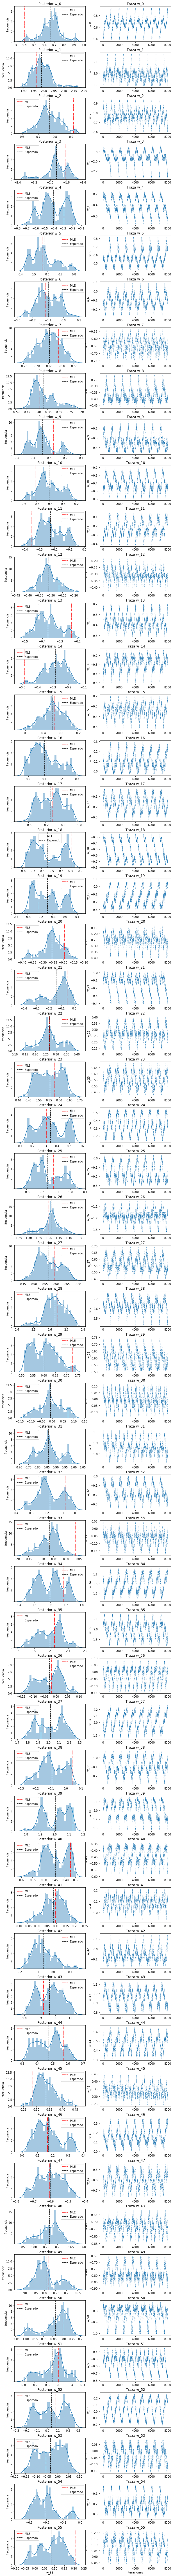

In [24]:
dir_fig = 'fig'
archivo_figura = f'{dir_fig}/prop-{std_poposal:.0e}_nsamples-{n_samples:.0e}.png'
sobrescribe = False

xx = np.arange(traza_concat.shape[0])
w_esperado = traza_concat.mean(0)

nrows, ncols = traza_concat.shape[1], 2
fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 3 * nrows), 
                         gridspec_kw={'hspace':.3})
for i in range(nrows):
    
    # histograma posterior
    ax_ = axes[i, 0]
    ax_.set_title('Posterior w_' + str(i))
    
    # evita FutureWarnings en distplot
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        sns.distplot(traza_concat[:, i], ax=ax_)
        
    ax_.set_ylabel('frecuencia')
    ax_.axvline(x=w_inicial[i], label='MLE', ls= '-.', c = 'r')
    ax_.axvline(x=w_esperado[i], label = 'Esperado',ls= '--', c='black')
    ax_.legend()
    
    # traza
    ax_ = axes[i, 1]
    ax_.scatter(x=xx, y = traza_concat[:, i], alpha=.6, s=.1)
    ax_.set_ylabel('w_' + str(i))
    ax_.set_title('Traza w_' + str(i))
    
axes[i, 0].set_xlabel('w_' + str(i));
axes[i, 1].set_xlabel('Iteraciones'); 
if (not os.path.isfile(archivo_figura)) or sobrescribe:
    fig.savefig(archivo_figura, bbxox_inches='tight')
else:
    print(f'Archivo existente,  y `sobrescribe` = {sobrescribe}')